In [ ]:
#cnn+lstm

In [1]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

# Data Generator without Augmentation
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        features = []
        for video_path in batch_x:
            frames = self.frames_extraction(video_path)
            features.append(frames)

        features = np.asarray(features)
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        return features, batch_y

    def frames_extraction(self, video_path):
        frames_list = []
        video_reader = cv2.VideoCapture(video_path)
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count / self.sequence_length), 1)

        for frame_counter in range(self.sequence_length):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            success, frame = video_reader.read()

            if not success:
                break

            resized_frame = cv2.resize(frame, (self.image_width, self.image_height))
            normalized_frame = resized_frame / 255.0
            frames_list.append(normalized_frame)

        video_reader.release()
        
        # If not enough frames, pad with zeros
        while len(frames_list) < self.sequence_length:
            frames_list.append(np.zeros((self.image_height, self.image_width, 3)))
        
        return np.array(frames_list)

# Load video paths and labels
def load_video_data(fighting_dir, normal_dir, abuse_dir, arson_dir, burglary_dir,
                    robbery_dir, shooting_dir, shoplifting_dir, stealing_dir, vandalism_dir,
                    limit_normal=298, limit_abuse=300, limit_arson=300, limit_burglary=300,
                    limit_robbery=300, limit_shooting=300, limit_shoplifting=250, limit_stealing=300, limit_vandalism=300):
    
    video_paths = []
    labels = []

    # Load fighting videos
    for video_name in os.listdir(fighting_dir):
        video_paths.append(os.path.join(fighting_dir, video_name))
        labels.append(0)  # Label for 'fighting'

    # Load normal videos, limit to `limit_normal`
    normal_videos = os.listdir(normal_dir)
    for video_name in normal_videos[:limit_normal]:
        video_paths.append(os.path.join(normal_dir, video_name))
        labels.append(1)  # Label for 'normal'

    # Load abuse videos, limit to `limit_abuse`
    abuse_videos = os.listdir(abuse_dir)
    for video_name in abuse_videos[:limit_abuse]:
        video_paths.append(os.path.join(abuse_dir, video_name))
        labels.append(2)  # Label for 'abuse'

    # Load arson videos, limit to `limit_arson`
    arson_videos = os.listdir(arson_dir)
    for video_name in arson_videos[:limit_arson]:
        video_paths.append(os.path.join(arson_dir, video_name))
        labels.append(3)  # Label for 'arson'

    # Load burglary videos, limit to `limit_burglary`
    burglary_videos = os.listdir(burglary_dir)
    for video_name in burglary_videos[:limit_burglary]:
        video_paths.append(os.path.join(burglary_dir, video_name))
        labels.append(4)  # Label for 'burglary'

    # Load robbery videos, limit to `limit_robbery`
    robbery_videos = os.listdir(robbery_dir)
    for video_name in robbery_videos[:limit_robbery]:
        video_paths.append(os.path.join(robbery_dir, video_name))
        labels.append(5)  # Label for 'robbery'

    # Load shooting videos, limit to `limit_shooting`
    shooting_videos = os.listdir(shooting_dir)
    for video_name in shooting_videos[:limit_shooting]:
        video_paths.append(os.path.join(shooting_dir, video_name))
        labels.append(6)  # Label for 'shooting'

    # Load shoplifting videos, limit to `limit_shoplifting`
    shoplifting_videos = os.listdir(shoplifting_dir)
    for video_name in shoplifting_videos[:limit_shoplifting]:
        video_paths.append(os.path.join(shoplifting_dir, video_name))
        labels.append(7)  # Label for 'shoplifting'

    # Load stealing videos, limit to `limit_stealing`
    stealing_videos = os.listdir(stealing_dir)
    for video_name in stealing_videos[:limit_stealing]:
        video_paths.append(os.path.join(stealing_dir, video_name))
        labels.append(8)  # Label for 'stealing'

    # Load vandalism videos, limit to `limit_vandalism`
    vandalism_videos = os.listdir(vandalism_dir)
    for video_name in vandalism_videos[:limit_vandalism]:
        video_paths.append(os.path.join(vandalism_dir, video_name))
        labels.append(9)  # Label for 'vandalism'
    
    return video_paths, labels

# Paths to the directories
base_dir_old = r"C:\Users\91920\Downloads\model old data\habu\data2"
base_dir_new = r"C:\Users\91920\Downloads\habu\data2" 

# Directories within 'model old data'
fighting_dir = os.path.join(base_dir_old, 'Fighting')
normal_dir = os.path.join(base_dir_old, 'Normal')
abuse_dir = os.path.join(base_dir_old, 'Abuse')

# Directories within 'habu\data'
arson_dir = r"C:\Users\91920\Downloads\model old data\habu\data2\Arson"
burglary_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Burglary'
robbery_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Robbery'
shooting_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Shooting'
shoplifting_dir =  r'C:\Users\91920\Downloads\model old data\habu\data2\Shoplifting'
stealing_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Stealing'
vandalism_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Vandalism'

# Load data with limits
video_paths, labels = load_video_data(
    fighting_dir, normal_dir, abuse_dir, arson_dir, burglary_dir, 
    robbery_dir, shooting_dir, shoplifting_dir, stealing_dir, vandalism_dir,
    limit_normal=298, limit_abuse=300, limit_arson=300, limit_burglary=300,
    limit_robbery=300, limit_shooting=300, limit_shoplifting=250, limit_stealing=300, limit_vandalism=300
)

# Split into training and testing data
video_paths_train, video_paths_test, labels_train, labels_test = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Data generator parameters
batch_size = 8
sequence_length = 20
image_height = 64
image_width = 64
num_classes = 10  # Updated number of classes

# Create dataset
def create_dataset(video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
    return VideoDataGenerator(
        video_paths=video_paths,
        labels=labels,
        batch_size=batch_size,
        sequence_length=sequence_length,
        image_height=image_height,
        image_width=image_width,
        num_classes=num_classes
    )

# Create data generators
train_generator = create_dataset(video_paths_train, labels_train, batch_size, sequence_length, image_height, image_width, num_classes)
test_generator = create_dataset(video_paths_test, labels_test, batch_size, sequence_length, image_height, image_width, num_classes)

# Revised LRCN Model Architecture with BiLSTM
from tensorflow.keras.regularizers import l2

# Revised LRCN Model Architecture with BiLSTM and Regularization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_LRCN_model_with_regularization(sequence_length, image_height, image_width, num_classes):
    model = Sequential()
    
    # TimeDistributed Convolutional layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))

    # LSTM layer with regularization
    model.add(LSTM(64, return_sequences=False, 
                   kernel_regularizer=l2(0.01),  # L2 regularization for weights
                   recurrent_regularizer=l2(0.01),  # L2 regularization for recurrent weights
                   bias_regularizer=l2(0.01)))  # L2 regularization for bias
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model_with_regularization = create_LRCN_model_with_regularization(sequence_length, image_height, image_width, num_classes)

# Model summary
model_with_regularization.summary()

# Define the callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('lstm_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=3, factor=0.1, monitor='val_loss', mode='min')
]

# Train the model with callbacks and store history
history = model_with_regularization.fit(train_generator,
                                        validation_data=test_generator,
                                        epochs=50,
                                        callbacks=callbacks)

# Evaluate on the test data
test_loss, test_accuracy = model_with_regularization.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 32, 32, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 64)   0

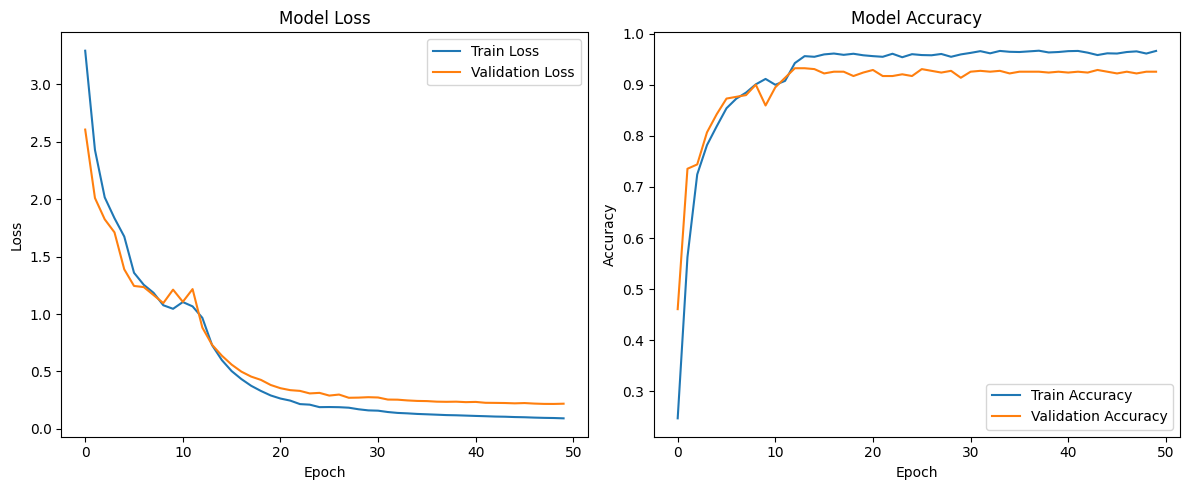

In [2]:
import matplotlib.pyplot as plt

# Plotting function for loss and accuracy
def plot_training_history(history):
    # Loss plot
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


In [ ]:
# import numpy as np
# import os
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.utils import Sequence, to_categorical

# # Directory paths for train/test/validation directories
# base_dir = r"C:\Users\91920\Downloads\major project final\data2 subset"

# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'valid')
# test_dir = os.path.join(base_dir, 'test')

# # Load data and labels from directories
# def load_dataset_from_directory(base_directory):
#     video_paths = []
#     labels = []
#     categories = os.listdir(base_directory)  # Assuming subdirectories are the class names
#     label_dict = {category: idx for idx, category in enumerate(categories)}

#     for category in categories:
#         category_dir = os.path.join(base_directory, category)
#         video_files = os.listdir(category_dir)
        
#         for video_file in video_files:
#             if video_file.endswith(('.mp4', '.avi', '.mkv')):  # Check for valid video file extensions
#                 video_path = os.path.join(category_dir, video_file)
#                 video_paths.append(video_path)
#                 labels.append(label_dict[category])  # Assign the corresponding label
    
#     return video_paths, labels, len(categories)

# # Load data for train, validation, and test sets
# train_video_paths, train_labels, num_classes = load_dataset_from_directory(train_dir)
# val_video_paths, val_labels, _ = load_dataset_from_directory(val_dir)
# test_video_paths, test_labels, _ = load_dataset_from_directory(test_dir)

# # Data generator class (unchanged)
# class VideoDataGenerator(Sequence):
#     def __init__(self, video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
#         self.video_paths = video_paths
#         self.labels = labels
#         self.batch_size = batch_size
#         self.sequence_length = sequence_length
#         self.image_height = image_height
#         self.image_width = image_width
#         self.num_classes = num_classes

#     def __len__(self):
#         return int(np.ceil(len(self.video_paths) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_x = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
#         features = []
#         for video_path in batch_x:
#             frames = self.frames_extraction(video_path)
#             features.append(frames)

#         features = np.asarray(features)
#         batch_y = to_categorical(batch_y, num_classes=self.num_classes)

#         return features, batch_y

#     def frames_extraction(self, video_path):
#         frames_list = []
#         video_reader = cv2.VideoCapture(video_path)
#         video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
#         skip_frames_window = max(int(video_frames_count / self.sequence_length), 1)

#         for frame_counter in range(self.sequence_length):
#             video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
#             success, frame = video_reader.read()

#             if not success:
#                 break

#             resized_frame = cv2.resize(frame, (self.image_width, self.image_height))
#             normalized_frame = resized_frame / 255.0
#             frames_list.append(normalized_frame)

#         video_reader.release()
        
#         # If not enough frames, pad with zeros
#         while len(frames_list) < self.sequence_length:
#             frames_list.append(np.zeros((self.image_height, self.image_width, 3)))
        
#         return np.array(frames_list)

# # Create dataset function (unchanged)
# def create_dataset(video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
#     return VideoDataGenerator(
#         video_paths=video_paths,
#         labels=labels,
#         batch_size=batch_size,
#         sequence_length=sequence_length,
#         image_height=image_height,
#         image_width=image_width,
#         num_classes=num_classes
#     )

# # Data generator parameters
# batch_size = 8
# sequence_length = 20
# image_height = 64
# image_width = 64

# # Create data generators
# train_generator = create_dataset(train_video_paths, train_labels, batch_size, sequence_length, image_height, image_width, num_classes)
# val_generator = create_dataset(val_video_paths, val_labels, batch_size, sequence_length, image_height, image_width, num_classes)
# test_generator = create_dataset(test_video_paths, test_labels, batch_size, sequence_length, image_height, image_width, num_classes)

# # Revised LRCN Model Architecture with BiLSTM (unchanged)
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, Flatten, Bidirectional
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dropout
# # Revised LRCN Model Architecture using MobileNetV2
# def create_BILRCN_model(sequence_length, image_height, image_width, num_classes):
#     model = Sequential()

#     # Use MobileNetV2 as the feature extractor
#     mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
#     mobilenet.trainable = False  # Freeze MobileNetV2 layers

#     # TimeDistributed MobileNetV2 for sequence processing
#     model.add(TimeDistributed(mobilenet, input_shape=(sequence_length, image_height, image_width, 3)))
#     model.add(TimeDistributed(Flatten()))

#     # BiLSTM layer for temporal sequence learning
#     model.add(Bidirectional(LSTM(64, return_sequences=False)))
#     model.add(Dropout(0.3))
#     # Final classification layer
#     model.add(Dense(num_classes, activation='softmax'))

#     model.summary()

#     return model

# # Create the model with MobileNetV2 and BiLSTM
# BILRCN_model = create_BILRCN_model(sequence_length, image_height, image_width, num_classes)

# # Compile the model with Adam optimizer
# BILRCN_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# # Callbacks remain the same
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
# # checkpoint_callback = ModelCheckpoint(r'C:\Users\91920\Downloads\final research paper\best_model_bilstm.h5', monitor='val_loss', save_best_only=True, mode='min')
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# # Train the model
# BILRCN_model_training_history = BILRCN_model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=val_generator,
#     callbacks=[early_stopping_callback,  reduce_lr_callback]
# )


In [ ]:
#bilstm

In [3]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

# Data Generator without Augmentation
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        features = []
        for video_path in batch_x:
            frames = self.frames_extraction(video_path)
            features.append(frames)

        features = np.asarray(features)
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        return features, batch_y

    def frames_extraction(self, video_path):
        frames_list = []
        video_reader = cv2.VideoCapture(video_path)
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count / self.sequence_length), 1)

        for frame_counter in range(self.sequence_length):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            success, frame = video_reader.read()

            if not success:
                break

            resized_frame = cv2.resize(frame, (self.image_width, self.image_height))
            normalized_frame = resized_frame / 255.0
            frames_list.append(normalized_frame)

        video_reader.release()
        
        # If not enough frames, pad with zeros
        while len(frames_list) < self.sequence_length:
            frames_list.append(np.zeros((self.image_height, self.image_width, 3)))
        
        return np.array(frames_list)

# Load video paths and labels
def load_video_data(fighting_dir, normal_dir, abuse_dir, arson_dir, burglary_dir,
                    robbery_dir, shooting_dir, shoplifting_dir, stealing_dir, vandalism_dir,
                    limit_normal=298, limit_abuse=300, limit_arson=300, limit_burglary=300,
                    limit_robbery=300, limit_shooting=300, limit_shoplifting=250, limit_stealing=300, limit_vandalism=300):
    
    video_paths = []
    labels = []

    # Load fighting videos
    for video_name in os.listdir(fighting_dir):
        video_paths.append(os.path.join(fighting_dir, video_name))
        labels.append(0)  # Label for 'fighting'

    # Load normal videos, limit to `limit_normal`
    normal_videos = os.listdir(normal_dir)
    for video_name in normal_videos[:limit_normal]:
        video_paths.append(os.path.join(normal_dir, video_name))
        labels.append(1)  # Label for 'normal'

    # Load abuse videos, limit to `limit_abuse`
    abuse_videos = os.listdir(abuse_dir)
    for video_name in abuse_videos[:limit_abuse]:
        video_paths.append(os.path.join(abuse_dir, video_name))
        labels.append(2)  # Label for 'abuse'

    # Load arson videos, limit to `limit_arson`
    arson_videos = os.listdir(arson_dir)
    for video_name in arson_videos[:limit_arson]:
        video_paths.append(os.path.join(arson_dir, video_name))
        labels.append(3)  # Label for 'arson'

    # Load burglary videos, limit to `limit_burglary`
    burglary_videos = os.listdir(burglary_dir)
    for video_name in burglary_videos[:limit_burglary]:
        video_paths.append(os.path.join(burglary_dir, video_name))
        labels.append(4)  # Label for 'burglary'

    # Load robbery videos, limit to `limit_robbery`
    robbery_videos = os.listdir(robbery_dir)
    for video_name in robbery_videos[:limit_robbery]:
        video_paths.append(os.path.join(robbery_dir, video_name))
        labels.append(5)  # Label for 'robbery'

    # Load shooting videos, limit to `limit_shooting`
    shooting_videos = os.listdir(shooting_dir)
    for video_name in shooting_videos[:limit_shooting]:
        video_paths.append(os.path.join(shooting_dir, video_name))
        labels.append(6)  # Label for 'shooting'

    # Load shoplifting videos, limit to `limit_shoplifting`
    shoplifting_videos = os.listdir(shoplifting_dir)
    for video_name in shoplifting_videos[:limit_shoplifting]:
        video_paths.append(os.path.join(shoplifting_dir, video_name))
        labels.append(7)  # Label for 'shoplifting'

    # Load stealing videos, limit to `limit_stealing`
    stealing_videos = os.listdir(stealing_dir)
    for video_name in stealing_videos[:limit_stealing]:
        video_paths.append(os.path.join(stealing_dir, video_name))
        labels.append(8)  # Label for 'stealing'

    # Load vandalism videos, limit to `limit_vandalism`
    vandalism_videos = os.listdir(vandalism_dir)
    for video_name in vandalism_videos[:limit_vandalism]:
        video_paths.append(os.path.join(vandalism_dir, video_name))
        labels.append(9)  # Label for 'vandalism'
    
    return video_paths, labels

# Paths to the directories
base_dir_old = r"C:\Users\91920\Downloads\model old data\habu\data2"
base_dir_new = r"C:\Users\91920\Downloads\habu\data2" 

# Directories within 'model old data'
fighting_dir = os.path.join(base_dir_old, 'Fighting')
normal_dir = os.path.join(base_dir_old, 'Normal')
abuse_dir = os.path.join(base_dir_old, 'Abuse')

# Directories within 'habu\data'
arson_dir = r"C:\Users\91920\Downloads\model old data\habu\data2\Arson"
burglary_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Burglary'
robbery_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Robbery'
shooting_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Shooting'
shoplifting_dir =  r'C:\Users\91920\Downloads\model old data\habu\data2\Shoplifting'
stealing_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Stealing'
vandalism_dir = r'C:\Users\91920\Downloads\model old data\habu\data2\Vandalism'

# Load data with limits
video_paths, labels = load_video_data(
    fighting_dir, normal_dir, abuse_dir, arson_dir, burglary_dir, 
    robbery_dir, shooting_dir, shoplifting_dir, stealing_dir, vandalism_dir,
    limit_normal=298, limit_abuse=300, limit_arson=300, limit_burglary=300,
    limit_robbery=300, limit_shooting=300, limit_shoplifting=250, limit_stealing=300, limit_vandalism=300
)

# Split into training and testing data
video_paths_train, video_paths_test, labels_train, labels_test = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Data generator parameters
batch_size = 8
sequence_length = 20
image_height = 64
image_width = 64
num_classes = 10  # Updated number of classes

# Create dataset
def create_dataset(video_paths, labels, batch_size, sequence_length, image_height, image_width, num_classes):
    return VideoDataGenerator(
        video_paths=video_paths,
        labels=labels,
        batch_size=batch_size,
        sequence_length=sequence_length,
        image_height=image_height,
        image_width=image_width,
        num_classes=num_classes
    )

# Create data generators
train_generator = create_dataset(video_paths_train, labels_train, batch_size, sequence_length, image_height, image_width, num_classes)
test_generator = create_dataset(video_paths_test, labels_test, batch_size, sequence_length, image_height, image_width, num_classes)

# Revised LRCN Model Architecture with BiLSTM
from tensorflow.keras.regularizers import l2

# Revised LRCN Model Architecture with BiLSTM and Regularization
def create_BILRCN_model_with_regularization(sequence_length, image_height, image_width, num_classes):
    model = Sequential()
    
    # TimeDistributed Convolutional layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))

    # LSTM layer with regularization
    model.add(Bidirectional(LSTM(64, return_sequences=False, 
                                 kernel_regularizer=l2(0.01), # L2 regularization for weights
                                 recurrent_regularizer=l2(0.01), # L2 regularization for recurrent weights
                                 bias_regularizer=l2(0.01)))) # L2 regularization for bias
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
import matplotlib.pyplot as plt

# Create the model
model_with_regularization = create_BILRCN_model_with_regularization(sequence_length, image_height, image_width, num_classes)

# Model summary
model_with_regularization.summary()

# Define the callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('bilstm_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=3, factor=0.1, monitor='val_loss', mode='min')
]

# Train the model with callbacks and store history
history = model_with_regularization.fit(train_generator,
                                        validation_data=test_generator,
                                        epochs=50,
                                        callbacks=callbacks)

# Evaluate on the test data
test_loss, test_accuracy = model_with_regularization.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 20, 64, 64, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 32, 32, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 16, 16, 64)  

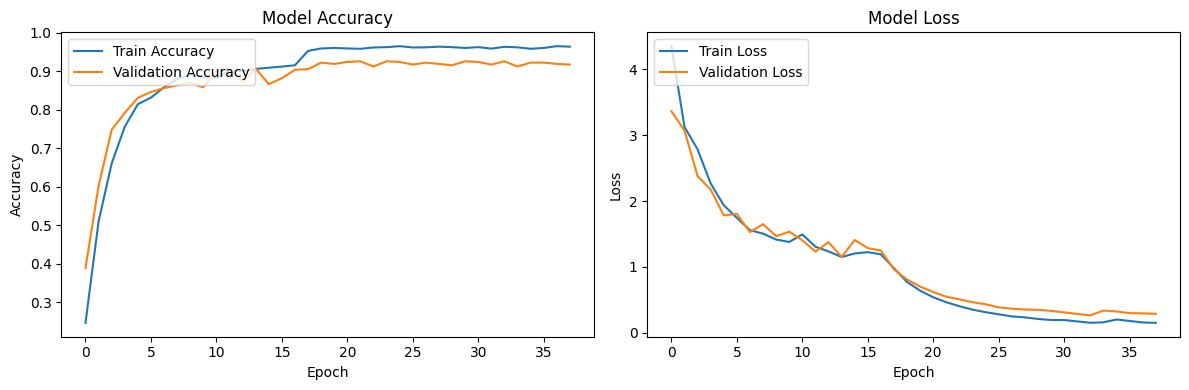

In [4]:
# Plotting the training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)



In [ ]:
#transformer approach multiple layer of transformers

In [45]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling1D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2

# # Custom Positional Encoding Layer
# class PositionalEncoding(Layer):
#     def __init__(self, sequence_length, embed_dim):
#         super(PositionalEncoding, self).__init__()
#         self.sequence_length = sequence_length
#         self.embed_dim = embed_dim
        
#         pos = np.arange(sequence_length)[:, np.newaxis]
#         i = np.arange(embed_dim)[np.newaxis, :]
#         angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
#         angle_rads = pos * angle_rates

#         # Apply sin to even indices in the array; 2i
#         angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

#         # Apply cos to odd indices in the array; 2i+1
#         angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

#         self.pos_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

#     def call(self, inputs):
#         return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#     def get_config(self):
#         config = super(PositionalEncoding, self).get_config()
#         config.update({
#             "sequence_length": self.sequence_length,
#             "embed_dim": self.embed_dim,
#         })
#         return config

# # Transformer block
# def transformer_block(embed_dim, num_heads, ff_dim):
#     inputs = tf.keras.Input(shape=(None, embed_dim))
#     attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#     attention_output = Dropout(0.1)(attention_output)
#     out1 = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

#     ffn_output = Dense(ff_dim, activation="relu")(out1)
#     ffn_output = Dense(embed_dim)(ffn_output)
#     ffn_output = Dropout(0.1)(ffn_output)
#     out2 = LayerNormalization(epsilon=1e-6)(ffn_output + out1)

#     return tf.keras.Model(inputs=inputs, outputs=out2)

# # Revised LRCN Model Architecture with Transformer
# # Revised Transformer Model with CNN and Positional Encoding
# def create_transformer_model(sequence_length, image_height, image_width, num_classes, embed_dim=64, num_heads=4, ff_dim=128):
#     model = Sequential()
    
#     # TimeDistributed Convolutional layers
#     model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
#                               input_shape=(sequence_length, image_height, image_width, 3)))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(Dropout(0.3)))
    
#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(Dropout(0.3)))
    
#     model.add(TimeDistributed(Flatten()))

#     # Reduce dimensionality with a Dense layer
#     model.add(TimeDistributed(Dense(embed_dim, activation='relu')))

#     # Add Positional Encoding
#     model.add(PositionalEncoding(sequence_length, embed_dim))

#     # Add multiple Transformer blocks
#     for _ in range(4):  # Add 4 transformer blocks
#         model.add(transformer_block(embed_dim, num_heads, ff_dim))

#     # Global average pooling
#     model.add(GlobalAveragePooling1D())

#     # Fully connected layers
#     model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     # model.add(Dropout(0.2))
#     model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     # model.add(Dropout(0.2))
    
#     # Output layer
#     model.add(Dense(num_classes, activation='softmax'))
    
#     # Compile the model
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

# # Create the transformer model
# model_with_transformer = create_transformer_model(sequence_length, image_height, image_width, num_classes)

# # Model summary
# model_with_transformer.summary()


# # Callbacks
# callbacks = [
#     EarlyStopping(patience=5, restore_best_weights=True),
#     ModelCheckpoint('best_transformer_multiple_layer_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
#     ReduceLROnPlateau(patience=3)
# ]

# # Train the model and save history
# history = model_with_transformer.fit(train_generator,
#                                      validation_data=test_generator,
#                                      epochs=50,
#                                      callbacks=callbacks)

# # Evaluate on the test data
# test_loss, test_accuracy = model_with_transformer.evaluate(test_generator)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")



Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_127 (TimeD  (None, 20, 64, 64, 32)   896       
 istributed)                                                     
                                                                 
 time_distributed_128 (TimeD  (None, 20, 32, 32, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_129 (TimeD  (None, 20, 32, 32, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_130 (TimeD  (None, 20, 32, 32, 64)   18496     
 istributed)                                                     
                                                                 
 time_distributed_131 (TimeD  (None, 20, 16, 16, 64) 

KeyboardInterrupt: 

In [38]:
# # Plotting function
# import matplotlib.pyplot as plt

# def plot_history(history):
#     # Plot training & validation accuracy values
#     plt.figure(figsize=(12, 4))
    
#     # Accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('Model accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')

#     # Loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')

#     plt.show()

# # Plot the training history
# plot_history(history)


NameError: name 'history' is not defined

In [ ]:
#transformer with single block ,relu activation

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Custom Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "embed_dim": self.embed_dim,
        })
        return config

# Transformer block
def transformer_block(embed_dim, num_heads, ff_dim):
    inputs = tf.keras.Input(shape=(None, embed_dim))
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(0.1)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(ffn_output + out1)

    return tf.keras.Model(inputs=inputs, outputs=out2)

# Revised LRCN Model Architecture with Transformer
# Revised Transformer Model with CNN and Positional Encoding
def create_transformer_model(sequence_length, image_height, image_width, num_classes, embed_dim=64, num_heads=4, ff_dim=128):
    model = Sequential()
    
    # TimeDistributed Convolutional layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))

    # Reduce dimensionality with a Dense layer
    model.add(TimeDistributed(Dense(embed_dim, activation='relu')))

    # Add Positional Encoding
    model.add(PositionalEncoding(sequence_length, embed_dim))

    # Add a single Transformer block
    model.add(transformer_block(embed_dim, num_heads, ff_dim))

    # Global average pooling
    model.add(GlobalAveragePooling1D())

    # Fully connected layers
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Create the transformer model
model_with_transformer = create_transformer_model(sequence_length, image_height, image_width, num_classes)

# Model summary
model_with_transformer.summary()


# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_transformer_relu_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=3)
]

# Train the model and save history
history = model_with_transformer.fit(train_generator,
                                     validation_data=test_generator,
                                     epochs=50,
                                     callbacks=callbacks)

# Evaluate on the test data
test_loss, test_accuracy = model_with_transformer.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 20, 64, 64, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 32, 32, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 16, 16, 64)  

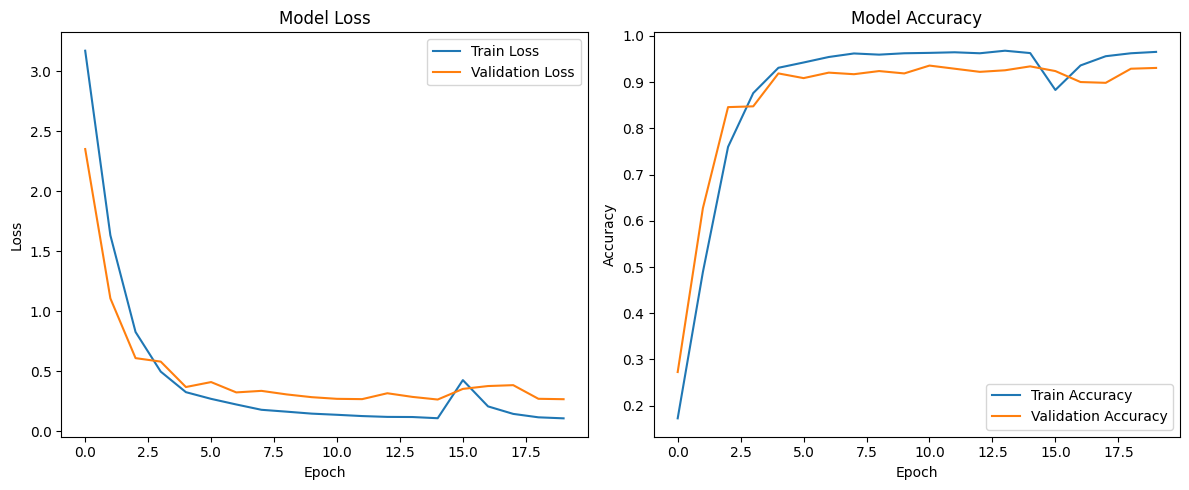

In [6]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_training_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


In [ ]:
#single transformer block with gelu 

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Custom Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "embed_dim": self.embed_dim,
        })
        return config

# Transformer block
def transformer_block(embed_dim, num_heads, ff_dim):
    inputs = tf.keras.Input(shape=(None, embed_dim))
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(0.1)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(ffn_output + out1)
    return tf.keras.Model(inputs=inputs, outputs=out2)

# Revised LRCN Model Architecture with Transformer
# Revised Transformer Model with CNN and Positional Encoding
from tensorflow.keras.activations import gelu

def create_transformer_model(sequence_length, image_height, image_width, num_classes, embed_dim=64, num_heads=4, ff_dim=128):
    model = Sequential()
    
    # TimeDistributed Convolutional layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='gelu'),
                              input_shape=(sequence_length, image_height, image_width, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='gelu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))

    # Reduce dimensionality with a Dense layer
    model.add(TimeDistributed(Dense(embed_dim, activation='gelu')))

    # Add Positional Encoding
    model.add(PositionalEncoding(sequence_length, embed_dim))

    # Add a single Transformer block
    model.add(transformer_block(embed_dim, num_heads, ff_dim))

    # Global average pooling
    model.add(GlobalAveragePooling1D())

    # Fully connected layers
    model.add(Dense(256, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



# Create the transformer model
model_with_transformer = create_transformer_model(sequence_length, image_height, image_width, num_classes)

# Model summary
model_with_transformer.summary()


# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_transformer_gelu_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(patience=3)
]

# Train the model and save history
history = model_with_transformer.fit(train_generator,
                                     validation_data=test_generator,
                                     epochs=50,
                                     callbacks=callbacks)

# Evaluate on the test data
test_loss, test_accuracy = model_with_transformer.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 20, 64, 64, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 20, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 32, 32, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 16, 16, 64)  

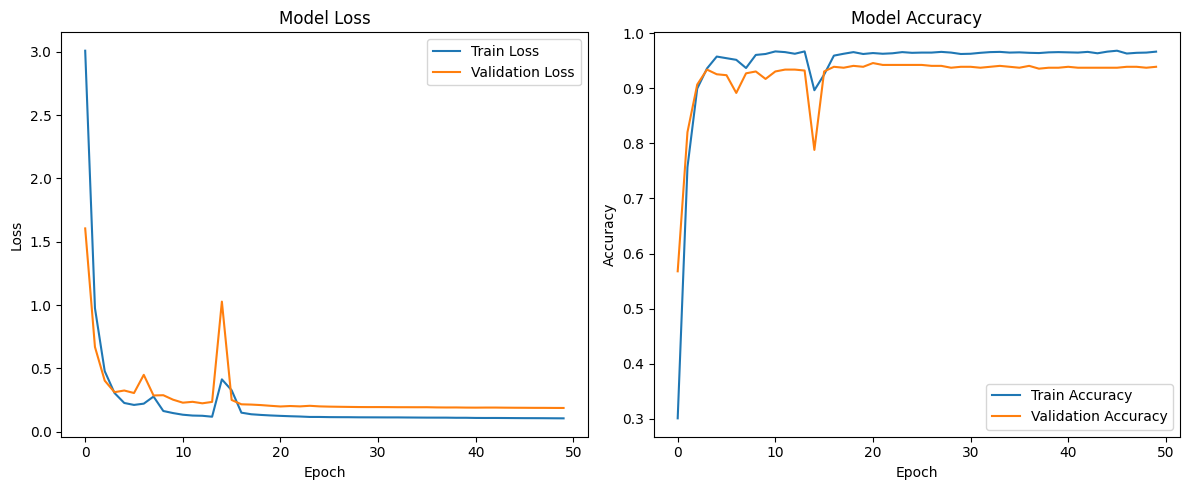

In [8]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_training_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


In [9]:
#fine tunning

In [10]:
# Continue training the model for 50 more epochs
history_additional = model_with_transformer.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,  # Set this to the total number of epochs you want
    initial_epoch=history.epoch[-1] + 1,  # Start from the last completed epoch
    callbacks=callbacks
)

# Evaluate on the test data
test_loss, test_accuracy = model_with_transformer.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 51/100
295/295 [==============================] - 222s 752ms/step - loss: 0.1037 - accuracy: 0.9643 - val_loss: 0.1861 - val_accuracy: 0.9373 - lr: 1.0000e-05
Epoch 52/100
295/295 [==============================] - 218s 739ms/step - loss: 0.1032 - accuracy: 0.9665 - val_loss: 0.1863 - val_accuracy: 0.9390 - lr: 1.0000e-05
Epoch 53/100
295/295 [==============================] - 218s 740ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.1861 - val_accuracy: 0.9390 - lr: 1.0000e-05
Epoch 54/100
295/295 [==============================] - 219s 741ms/step - loss: 0.1033 - accuracy: 0.9635 - val_loss: 0.1860 - val_accuracy: 0.9390 - lr: 1.0000e-05
Epoch 55/100
295/295 [==============================] - 221s 747ms/step - loss: 0.1025 - accuracy: 0.9665 - val_loss: 0.1852 - val_accuracy: 0.9390 - lr: 1.0000e-05
Epoch 56/100
295/295 [==============================] - 218s 739ms/step - loss: 0.1019 - accuracy: 0.9673 - val_loss: 0.1849 - val_accuracy: 0.9373 - lr: 1.0000e-05
Epoch 57/1

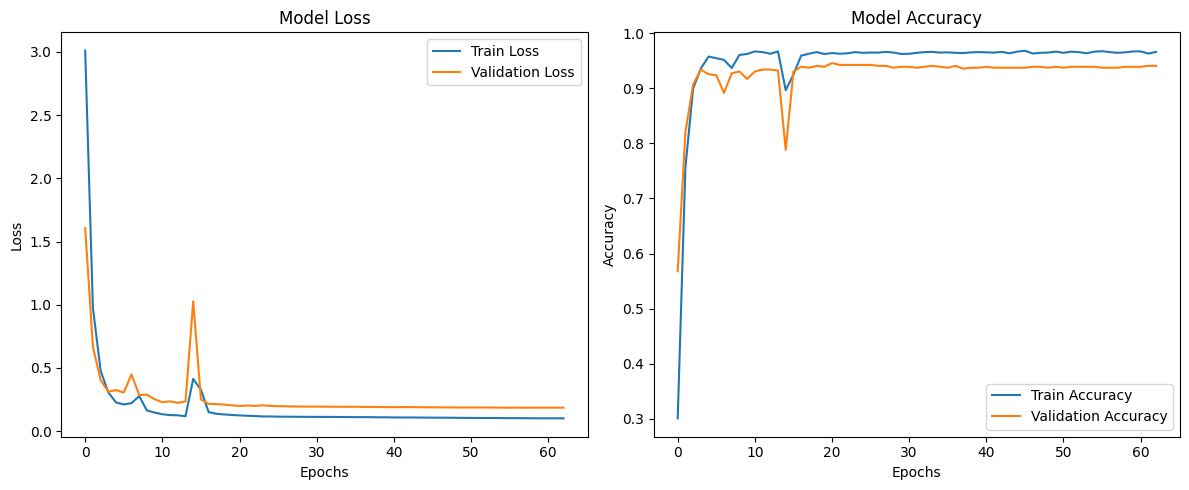

In [13]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Now call the function with the combined history
plot_training_history(combined_history)


In [11]:
import sys
print(sys.version)

3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:38:46) [MSC v.1929 64 bit (AMD64)]


In [12]:
pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\programdata\anaconda3\envs\t210\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [14]:
!conda list cudatoolkit


# packages in environment at C:\ProgramData\Anaconda3\envs\t210:
#
# Name                    Version                   Build  Channel
cudatoolkit               11.2.2              h7d7167e_13    conda-forge
